In [3]:
import pandas as pd

trades = pd.read_csv("/content/historical_data.csv")
sentiment = pd.read_csv("/content/fear_greed_index.csv")

# Basic inspection
print("Trader Data Shape:", trades.shape)
print("Sentiment Data Shape:", sentiment.shape)




Trader Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)


In [4]:

trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [5]:
sentiment.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


### Dataset Overview

- The trader dataset contains execution-level trading records including
  price, size, side, leverage, and realized PnL.
- The Fear & Greed dataset provides daily market sentiment classification
  used as a macro-level indicator.


In [6]:
sentiment.columns = sentiment.columns.str.strip().str.lower()


In [8]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [9]:
sentiment['sentiment_group'] = sentiment['classification'].replace({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Extreme Greed': 'Greed',
    'Greed': 'Greed'
})


In [10]:
sentiment[['date', 'classification', 'sentiment_group']].head()


,date,classification,sentiment_group
0,2018-02-01,Fear,Fear
1,2018-02-02,Extreme Fear,Fear
2,2018-02-03,Fear,Fear
3,2018-02-04,Extreme Fear,Fear
4,2018-02-05,Extreme Fear,Fear


In [17]:
print(trades.columns)
print(sentiment.columns)


Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date', 'sentiment_group'], dtype='object')


In [19]:
trades.columns = trades.columns.str.strip().str.replace(" ", "_").str.lower()
sentiment.columns = sentiment.columns.str.strip().str.lower()

# Create time + date column in trades
trades['time'] = pd.to_datetime(
    trades['timestamp_ist'],
    dayfirst=True,
    errors='coerce'
)
trades['date'] = trades['time'].dt.date

# Ensure date exists in sentiment
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [22]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [23]:
df = trades.merge(
    sentiment[['date', 'sentiment_group']],
    on='date',
    how='left'
)


In [25]:
import os

os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [26]:
df.to_csv("csv_files/merged_sentiment_trades.csv", index=False)


In [27]:
!ls csv_files


merged_sentiment_trades.csv


## Feature Engineering


In [28]:
# Profitability flag
df['is_profitable'] = df['closed_pnl'] > 0

# Trade value in USD (volume proxy)
df['trade_value'] = df['execution_price'] * df['size_usd']

# Direction normalization
df['side'] = df['side'].str.upper()


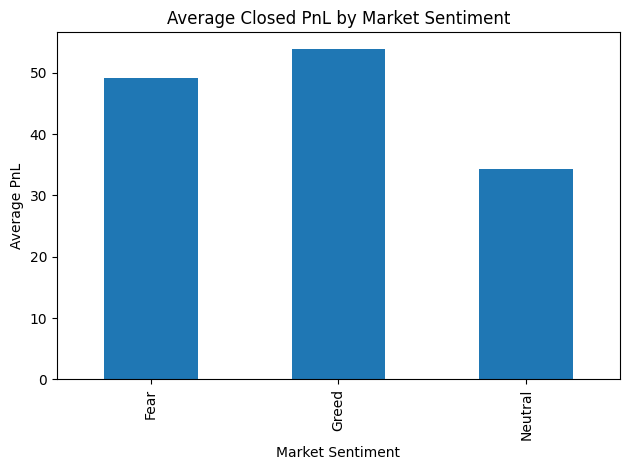

In [29]:
import matplotlib.pyplot as plt

pnl_sentiment = df.groupby('sentiment_group')['closed_pnl'].mean()

pnl_sentiment.plot(kind='bar')
plt.title("Average Closed PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.tight_layout()
plt.savefig("outputs/avg_pnl_by_sentiment.png", dpi=300)
plt.show()


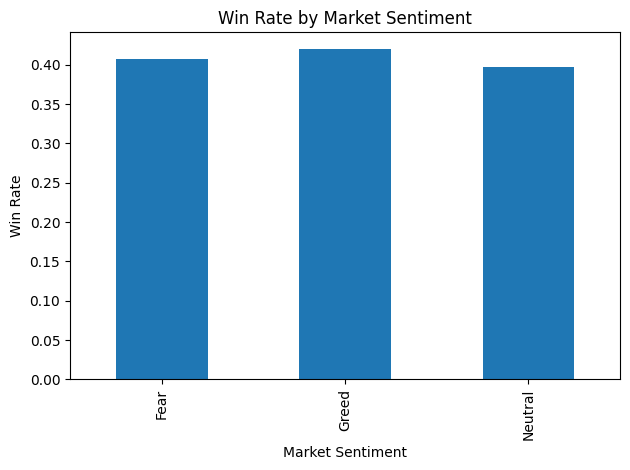

In [30]:
winrate = df.groupby('sentiment_group')['is_profitable'].mean()

winrate.plot(kind='bar')
plt.title("Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.tight_layout()
plt.savefig("outputs/winrate_by_sentiment.png", dpi=300)
plt.show()


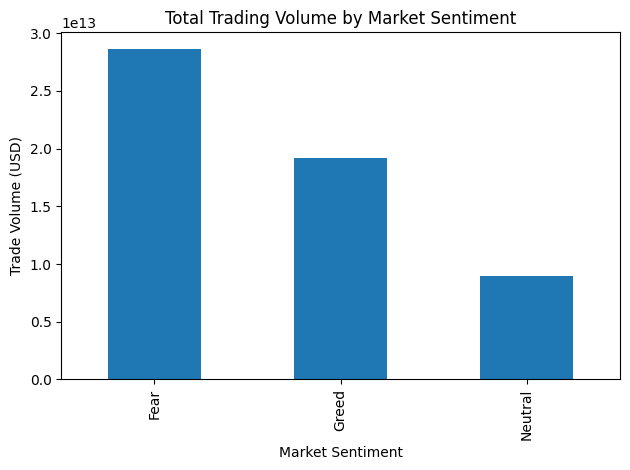

In [32]:
volume_sentiment = df.groupby('sentiment_group')['trade_value'].sum()

volume_sentiment.plot(kind='bar')
plt.title("Total Trading Volume by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Trade Volume (USD)")
plt.tight_layout()
plt.savefig("outputs/volume_by_sentiment.png", dpi=300)
plt.show()


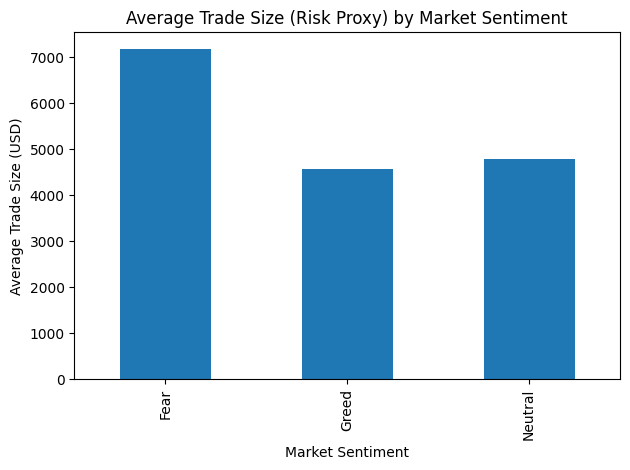

In [35]:
risk_sentiment = df.groupby('sentiment_group')['size_usd'].mean()

risk_sentiment.plot(kind='bar')
plt.title("Average Trade Size (Risk Proxy) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.tight_layout()
plt.savefig("outputs/risk_proxy_by_sentiment.png", dpi=300)
plt.show()


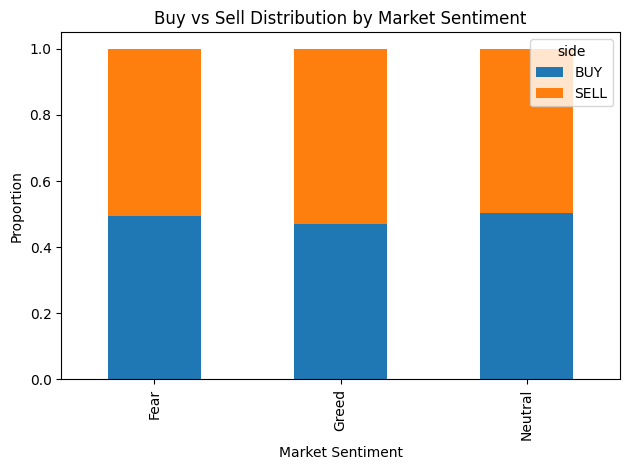

In [36]:
side_dist = pd.crosstab(df['sentiment_group'], df['side'], normalize='index')

side_dist.plot(kind='bar', stacked=True)
plt.title("Buy vs Sell Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Proportion")
plt.tight_layout()
plt.savefig("outputs/buy_sell_by_sentiment.png", dpi=300)
plt.show()


In [39]:
# Ultra-small aggregated CSV for GitHub
summary_df = df.groupby('sentiment_group').agg(
    total_trades=('trade_id', 'count'),
    avg_pnl=('closed_pnl', 'mean'),
    win_rate=('is_profitable', 'mean'),
    avg_trade_size_usd=('size_usd', 'mean')
).reset_index()

summary_df.to_csv("csv_files/sentiment_summary.csv", index=False)

summary_df


,sentiment_group,total_trades,avg_pnl,win_rate,avg_trade_size_usd
0,Fear,83237,49.212077,0.407871,7182.011019
1,Greed,90295,53.882281,0.420311,4574.424490
2,Neutral,37686,34.307718,0.396991,4782.732661
